In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.6em;
line-height:1.4em
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.3em;
line-height:1.4em;
padding-right:3em;
}
</style>
""")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from itertools import cycle, islice
import pylab as pl
import operator
import re
from collections import OrderedDict
import pickle
import matplotlib.colors as colors
import math
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


1.Data Reading and Preprocessing 

The data comes as a comma separated text file. Before exploring the data, I need to first do some clean-up work. Using my existing knowledge of IRS data, I know several variables are not relevant to this type of analysis, so I drop those.In addition, a few variables have missing values, but since I know they are indicator variables, I know these are not true missing values, so I replaced missing values with 0's for these variables. In addition, I use an existing variable, disp_cd, to create a new variable to show which cases were found to be fraudulent and which were found to be non-fraudulent after audit (new variable 'AUDIT_RESULT2'). 

In [3]:
#seaborn settings
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8,4)})

#set pandas so i can view all dataframne columns
pd.set_option('display.max_columns', None)

#import csv file
PTCAudit = pd.read_csv('PTCAuditcases.csv',low_memory=False)
PTCAudit.head()

,Unnamed: 0,unmasked_tin,Tax_Period,Dln,Cycle_Scored,Cycle_Selected,Cycle_Updated,Scored_Date,Bod_Cd,Filing_Status,City,State,First_Time_Filer,Sch_C_E_F_Ind,Prisoner_Ind,Taxpayer_Age,Scnd_Taxpayer_Age,Primary_Dob,Idt_Cond,Dependent_Ind,Ranking,Prior_Ty_Filing_Status,Bal_Due_Amt_Comp,Agi_Comp,Wages,Tot_Income,Sch_C_Prof_Loss_Amt,Fpl_Pct_Comp,Sch_C_To_Agi_Pct_Comp,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Amt_From_1040,Aptc_Amt_From_1040,Exempt_Amt_Comp,Annl_SLCSP_Prem_Comp,Prior_Ty_Exemptions,Current_Ty_Exemptions,Hardship_Ind,Fed_Pvrty_Lvl_Ind,Pre_Post_Selection,Avs_Bypass_Ind,Exposure_Amt,Family_Size,Ptc_Magi_Amt,Household_Income_Amt,Fed_Poverty_Level_Amt,Household_Inc_Percent_Fpl,Applicable_Figure_Amt,Annual_Contrib_Health_Care_Amt,Ptc_Amt_Comp,Aptc_Amt_Comp,Recon_Ptc_Amt,Exc_Aptc_Amt,Exc_Aptc_Lim_Amt,Aptc_Repay_Amt,Exposure_Amt_Sum,Family_Size_Sum,Ptc_Magi_Amt_Sum,Household_Income_Amt_Sum,Fed_Poverty_Level_Amt_Sum,Household_Inc_Percent_Fpl_Sum,Applicable_Figure_Amt_Sum,Annual_Contrib_Hlth_Care_Amt_Sum,Ptc_Amt_Comp_Sum,Aptc_Amt_Comp_Sum,Recon_Ptc_Amt_Sum,Exc_Aptc_Amt_Sum,Exc_Aptc_Lim_Amt_Sum,Aptc_Repay_Amt_Sum,PTC_Scored_Count,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,FilStatFinal,AGIFinal,Sch_C_Prof_Loss_AmtFinal,Fpl_Pct_CompFinal,Exposure_AmtFinal,Bal_Due_Amt_CompFinal,Ptc_Ind,tin,DISP_CD
0,0,1383627,201412,16209431351225,201514,201514.0,201514.0,20150403,WI,2,JAMESTOWN,RI,NaN,0,NaN,65,62,19490718.0,X,NaN,7.0,2.0,-3389,63447,8959,63447,0,409.07,0.0,0.00,0,0,15510,5805,2,2,0,NaN,PRE,NaN,5295,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,5295,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2-MFJ,"7-$50,001 to $75,000",6- $0,5- Greater than 400%,"11- $3,500 or more","1- Equal or Less than -$2,500",0,2077793,4
1,1,1423071,201412,80211440773575,201517,201517.0,201517.0,20150427,WI,1,NORTH LAS VEGAS,NV,NaN,0,NaN,59,0,19550228.0,X,NaN,50.0,1.0,-3592,31143,27146,31143,0,271.04,0.0,9.64,3003,0,11490,5700,1,1,0,C,PRE,NaN,3753,1,31143,31143,11490,271,0.0866,2697,3003,0,3003,0,0,0,3753,1,31143,31143,11490,271,0.0866,2697,3003,0,3003,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1-Single,"5-$30,001 to $40,000",6- $0,3- 201% to 300%,"11- $3,500 or more","1- Equal or Less than -$2,500",1,2136992,4
2,2,1427600,201412,9221165274195,201535,201535.0,201535.0,20150903,SB,3,KITTERY POINT,ME,NaN,10,NaN,53,0,19610907.0,X,1.0,7.0,3.0,35057,99074,0,108085,0,862.26,0.0,0.00,0,0,11490,8940,2,1,0,NaN,PRE,NaN,3400,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,3400,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3-MFS,"8-$75,001 to $100,000",6- $0,5- Greater than 400%,"10- $2,500 to $3,499","9- $2,500 or more",0,2143790,4
3,3,1468845,201412,9222105633345,201528,201528.0,201528.0,20150713,WI,2,MANCHESTER,NH,NaN,0,NaN,63,58,19510916.0,X,NaN,7.0,2.0,3671,58231,0,58231,0,375.44,0.0,0.00,0,0,15510,12852,2,2,0,NaN,PRE,NaN,9774,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,9774,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2-MFJ,"7-$50,001 to $75,000",6- $0,4- 301% to 400%,"11- $3,500 or more","9- $2,500 or more",0,2205691,4
4,4,1564415,201412,16207438202505,201524,201524.0,201524.0,20150615,WI,2,MEREDITH,NH,NaN,0,NaN,51,48,19631014.0,X,NaN,7.0,2.0,-366,62656,62656,62656,0,403.97,0.0,0.00,0,0,15510,11610,2,2,0,NaN,PRE,NaN,3255,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,3255,0,0,0,0,0,0.0000,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2-MFJ,"7-$50,001 to $75,000",6- $0,5- Greater than 400%,"10- $2,500 to $3,499",4- -$499 to -$1,0,2349124,4


In [4]:
#create variable 'Audit_Result' to show good vs. bad cases and numerical variable for bod code
PTCAudit.loc[(PTCAudit['DISP_CD'] > 0) & (PTCAudit['DISP_CD'] < 3), 'AUDIT_RESULT2'] = 0
PTCAudit.loc[(PTCAudit['DISP_CD'] > 2), 'AUDIT_RESULT2'] = 1
PTCAudit.loc[(PTCAudit['Bod_Cd'] == 'SB'), 'Bod_Cd2'] = 1
PTCAudit.loc[(PTCAudit['Bod_Cd'] == 'WI'), 'Bod_Cd2'] = 2
PTCAudit = PTCAudit[PTCAudit.columns.difference(['Bod_Cd'])]
PTCAudit
PTCAudit.head()

,AGIFinal,AUDIT_RESULT2,Agi_Comp,Annl_SLCSP_Prem_Comp,Annual_Contrib_Health_Care_Amt,Annual_Contrib_Hlth_Care_Amt_Sum,Applicable_Figure_Amt,Applicable_Figure_Amt_Sum,Aptc_Amt_Comp,Aptc_Amt_Comp_Sum,Aptc_Amt_From_1040,Aptc_Repay_Amt,Aptc_Repay_Amt_Sum,Avs_Bypass_Ind,Bal_Due_Amt_Comp,Bal_Due_Amt_CompFinal,Bod_Cd2,City,Current_Ty_Exemptions,Cycle_Scored,Cycle_Selected,Cycle_Updated,DISP_CD,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,Dependent_Ind,Dln,Exc_Aptc_Amt,Exc_Aptc_Amt_Sum,Exc_Aptc_Lim_Amt,Exc_Aptc_Lim_Amt_Sum,Exempt_Amt_Comp,Exposure_Amt,Exposure_AmtFinal,Exposure_Amt_Sum,Family_Size,Family_Size_Sum,Fed_Poverty_Level_Amt,Fed_Poverty_Level_Amt_Sum,Fed_Pvrty_Lvl_Ind,FilStatFinal,Filing_Status,First_Time_Filer,Fpl_Pct_Comp,Fpl_Pct_CompFinal,Hardship_Ind,Household_Inc_Percent_Fpl,Household_Inc_Percent_Fpl_Sum,Household_Income_Amt,Household_Income_Amt_Sum,Idt_Cond,PTC_Scored_Count,Pre_Post_Selection,Primary_Dob,Prior_Ty_Exemptions,Prior_Ty_Filing_Status,Prisoner_Ind,Ptc_Amt_Comp,Ptc_Amt_Comp_Sum,Ptc_Amt_From_1040,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ptc_Ind,Ptc_Magi_Amt,Ptc_Magi_Amt_Sum,Ranking,Recon_Ptc_Amt,Recon_Ptc_Amt_Sum,Sch_C_E_F_Ind,Sch_C_Prof_Loss_Amt,Sch_C_Prof_Loss_AmtFinal,Sch_C_To_Agi_Pct_Comp,Scnd_Taxpayer_Age,Scored_Date,State,Tax_Period,Taxpayer_Age,Tot_Income,Unnamed: 0,Wages,tin,unmasked_tin
0,"7-$50,001 to $75,000",1.0,63447,5805,0,0,0.0000,0.0000,0,0,0,0,0,NaN,-3389,"1- Equal or Less than -$2,500",2.0,JAMESTOWN,2,201514,201514.0,201514.0,4,0,0,0,0,0,0,0,1,0,0,NaN,16209431351225,0,0,0,0,15510,5295,"11- $3,500 or more",5295,0,0,0,0,NaN,2-MFJ,2,NaN,409.07,5- Greater than 400%,0,0,0,0,0,X,1,PRE,19490718.0,2,2.0,NaN,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,7.0,0,0,0,0,6- $0,0.0,62,20150403,RI,201412,65,63447,0,8959,2077793,1383627
1,"5-$30,001 to $40,000",1.0,31143,5700,2697,2697,0.0866,0.0866,0,0,0,0,0,NaN,-3592,"1- Equal or Less than -$2,500",2.0,NORTH LAS VEGAS,1,201517,201517.0,201517.0,4,0,0,0,0,0,0,0,0,0,0,NaN,80211440773575,0,0,0,0,11490,3753,"11- $3,500 or more",3753,1,1,11490,11490,C,1-Single,1,NaN,271.04,3- 201% to 300%,0,271,271,31143,31143,X,1,PRE,19550228.0,1,1.0,NaN,3003,3003,3003,9.64,0,0,0,0,0,0,0,0,1,0,1,31143,31143,50.0,3003,3003,0,0,6- $0,0.0,0,20150427,NV,201412,59,31143,1,27146,2136992,1423071
2,"8-$75,001 to $100,000",1.0,99074,8940,0,0,0.0000,0.0000,0,0,0,0,0,NaN,35057,"9- $2,500 or more",1.0,KITTERY POINT,1,201535,201535.0,201535.0,4,0,0,0,0,0,0,0,1,0,0,1.0,9221165274195,0,0,0,0,11490,3400,"10- $2,500 to $3,499",3400,0,0,0,0,NaN,3-MFS,3,NaN,862.26,5- Greater than 400%,0,0,0,0,0,X,1,PRE,19610907.0,2,3.0,NaN,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,7.0,0,0,10,0,6- $0,0.0,0,20150903,ME,201412,53,108085,2,0,2143790,1427600
3,"7-$50,001 to $75,000",1.0,58231,12852,0,0,0.0000,0.0000,0,0,0,0,0,NaN,3671,"9- $2,500 or more",2.0,MANCHESTER,2,201528,201528.0,201528.0,4,0,0,0,0,0,0,0,1,0,0,NaN,9222105633345,0,0,0,0,15510,9774,"11- $3,500 or more",9774,0,0,0,0,NaN,2-MFJ,2,NaN,375.44,4- 301% to 400%,0,0,0,0,0,X,1,PRE,19510916.0,2,2.0,NaN,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,7.0,0,0,0,0,6- $0,0.0,58,20150713,NH,201412,63,58231,3,0,2205691,1468845
4,"7-$50,001 to $75,000",1.0,62656,11610,0,0,0.0000,0.0000,0,0,0,0,0,NaN,-366,4- -$499 to -$1,2.0,MEREDITH,2,201524,201524.0,201524.0,4,0,0,0,0,0,0,0,1,0,0,NaN,16207438202505,0,0,0,0,15510,3255,"10- $2,500 to $3,499",3255,0,0,0,0,NaN,2-MFJ,2,NaN,403.97,5- Greater than 400%,0,0,0,0,0,X,1,PRE,19631014.0,2,2.0,NaN,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,7.0,0,0,0,0,6- $0,0.0,48,20150615,NH,201412,51,62656,4,62656,2349124,1564415


In [5]:
#Drop certain variables based on technical knowledge of IRS variables 
PTCAudit2 = PTCAudit[PTCAudit.columns.difference([
'unmasked_tin', 'tin' , 'AGIFinal','Bal_Due_Amt_CompFinal','City', 'DISP_CD','State','Bod','Exposure_AmtFinal','FilStatFinal',
'Fpl_Pct_CompFinal','Prisoner_Ind', 'Sch_C_Prof_Loss_AmtFinal','Idt_Cond', 'Fed_Pvrty_Lvl_Ind','Cycle_Selected', 'Cycle_Updated',
'Tax_Period', 'Dln','Ranking', 'Pre_Post_Selection', 'Avs_Bypass_Ind', 'PTC_Scored_Count'])]
PTCAudit2.head()

,AUDIT_RESULT2,Agi_Comp,Annl_SLCSP_Prem_Comp,Annual_Contrib_Health_Care_Amt,Annual_Contrib_Hlth_Care_Amt_Sum,Applicable_Figure_Amt,Applicable_Figure_Amt_Sum,Aptc_Amt_Comp,Aptc_Amt_Comp_Sum,Aptc_Amt_From_1040,Aptc_Repay_Amt,Aptc_Repay_Amt_Sum,Bal_Due_Amt_Comp,Bod_Cd2,Current_Ty_Exemptions,Cycle_Scored,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,Dependent_Ind,Exc_Aptc_Amt,Exc_Aptc_Amt_Sum,Exc_Aptc_Lim_Amt,Exc_Aptc_Lim_Amt_Sum,Exempt_Amt_Comp,Exposure_Amt,Exposure_Amt_Sum,Family_Size,Family_Size_Sum,Fed_Poverty_Level_Amt,Fed_Poverty_Level_Amt_Sum,Filing_Status,First_Time_Filer,Fpl_Pct_Comp,Hardship_Ind,Household_Inc_Percent_Fpl,Household_Inc_Percent_Fpl_Sum,Household_Income_Amt,Household_Income_Amt_Sum,Primary_Dob,Prior_Ty_Exemptions,Prior_Ty_Filing_Status,Ptc_Amt_Comp,Ptc_Amt_Comp_Sum,Ptc_Amt_From_1040,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ptc_Ind,Ptc_Magi_Amt,Ptc_Magi_Amt_Sum,Recon_Ptc_Amt,Recon_Ptc_Amt_Sum,Sch_C_E_F_Ind,Sch_C_Prof_Loss_Amt,Sch_C_To_Agi_Pct_Comp,Scnd_Taxpayer_Age,Scored_Date,Taxpayer_Age,Tot_Income,Unnamed: 0,Wages
0,1.0,63447,5805,0,0,0.0000,0.0000,0,0,0,0,0,-3389,2.0,2,201514,0,0,0,0,0,0,0,1,0,0,NaN,0,0,0,0,15510,5295,5295,0,0,0,0,2,NaN,409.07,0,0,0,0,0,19490718.0,2,2.0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,62,20150403,65,63447,0,8959
1,1.0,31143,5700,2697,2697,0.0866,0.0866,0,0,0,0,0,-3592,2.0,1,201517,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,11490,3753,3753,1,1,11490,11490,1,NaN,271.04,0,271,271,31143,31143,19550228.0,1,1.0,3003,3003,3003,9.64,0,0,0,0,0,0,0,0,1,0,1,31143,31143,3003,3003,0,0,0.0,0,20150427,59,31143,1,27146
2,1.0,99074,8940,0,0,0.0000,0.0000,0,0,0,0,0,35057,1.0,1,201535,0,0,0,0,0,0,0,1,0,0,1.0,0,0,0,0,11490,3400,3400,0,0,0,0,3,NaN,862.26,0,0,0,0,0,19610907.0,2,3.0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0.0,0,20150903,53,108085,2,0
3,1.0,58231,12852,0,0,0.0000,0.0000,0,0,0,0,0,3671,2.0,2,201528,0,0,0,0,0,0,0,1,0,0,NaN,0,0,0,0,15510,9774,9774,0,0,0,0,2,NaN,375.44,0,0,0,0,0,19510916.0,2,2.0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,58,20150713,63,58231,3,0
4,1.0,62656,11610,0,0,0.0000,0.0000,0,0,0,0,0,-366,2.0,2,201524,0,0,0,0,0,0,0,1,0,0,NaN,0,0,0,0,15510,3255,3255,0,0,0,0,2,NaN,403.97,0,0,0,0,0,19631014.0,2,2.0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,48,20150615,51,62656,4,62656


In [6]:
#examine variables with missing data
pd.set_option('display.max_rows', 100)
PTCAudit2.isnull().sum()

AUDIT_RESULT2                          0
Agi_Comp                               0
Annl_SLCSP_Prem_Comp                   0
Annual_Contrib_Health_Care_Amt         0
Annual_Contrib_Hlth_Care_Amt_Sum       0
Applicable_Figure_Amt                  0
Applicable_Figure_Amt_Sum              0
Aptc_Amt_Comp                          0
Aptc_Amt_Comp_Sum                      0
Aptc_Amt_From_1040                     0
Aptc_Repay_Amt                         0
Aptc_Repay_Amt_Sum                     0
Bal_Due_Amt_Comp                       0
Bod_Cd2                                0
Current_Ty_Exemptions                  0
Cycle_Scored                           0
Ddb_Ptc_900_Cdb                        0
Ddb_Ptc_901_Cdb                        0
Ddb_Ptc_902_Cdb                        0
Ddb_Ptc_903_Cdb                        0
Ddb_Ptc_904_Cdb                        0
Ddb_Ptc_910_Cdb                        0
Ddb_Ptc_911_Cdb                        0
Ddb_Ptc_912_Cdb                        0
Ddb_Ptc_913_Cdb 

In [7]:
#replace variable missing values with 0's since these are indicators
pd.set_option('display.max_rows', 100)
PTCAudit3=PTCAudit2.fillna(0)
PTCAudit3.isnull().sum()

AUDIT_RESULT2                       0
Agi_Comp                            0
Annl_SLCSP_Prem_Comp                0
Annual_Contrib_Health_Care_Amt      0
Annual_Contrib_Hlth_Care_Amt_Sum    0
Applicable_Figure_Amt               0
Applicable_Figure_Amt_Sum           0
Aptc_Amt_Comp                       0
Aptc_Amt_Comp_Sum                   0
Aptc_Amt_From_1040                  0
Aptc_Repay_Amt                      0
Aptc_Repay_Amt_Sum                  0
Bal_Due_Amt_Comp                    0
Bod_Cd2                             0
Current_Ty_Exemptions               0
Cycle_Scored                        0
Ddb_Ptc_900_Cdb                     0
Ddb_Ptc_901_Cdb                     0
Ddb_Ptc_902_Cdb                     0
Ddb_Ptc_903_Cdb                     0
Ddb_Ptc_904_Cdb                     0
Ddb_Ptc_910_Cdb                     0
Ddb_Ptc_911_Cdb                     0
Ddb_Ptc_912_Cdb                     0
Ddb_Ptc_913_Cdb                     0
Ddb_Ptc_914_Cdb                     0
Dependent_In

2.Data Exploration

First, I examined the breakout of my target variable, AUDIT_RESULT2, to see if it's a rare target and if I would subsequently need to do any class balancing. 

Since there so many variables in my dataset, I wanted to get a sense for which ones have the highest impact on whether a return claiming the PTC is fradulent or not. To see see these linear relationships, I printed a correlation matrix.

In [8]:
#examine breakout of target variable 
f=PTCAudit3 
f = pd.Series(f.AUDIT_RESULT2).value_counts().reset_index().sort_values('index').reset_index(drop=True)
f.columns = ['AUDIT_RESULT2', 'Frequency']
print (f)

   AUDIT_RESULT2  Frequency
0            0.0       2475
1            1.0       5963


In [9]:
PTCAudit3.shape

(8438, 77)

Upon review, 71% of cases in the dataset are fraudulent. 

In [10]:
#run a correlation matrix to examine relationships between input variables and fraud
pd.set_option('display.max_rows', 100)
PTCAudit3.corr()

,AUDIT_RESULT2,Agi_Comp,Annl_SLCSP_Prem_Comp,Annual_Contrib_Health_Care_Amt,Annual_Contrib_Hlth_Care_Amt_Sum,Applicable_Figure_Amt,Applicable_Figure_Amt_Sum,Aptc_Amt_Comp,Aptc_Amt_Comp_Sum,Aptc_Amt_From_1040,Aptc_Repay_Amt,Aptc_Repay_Amt_Sum,Bal_Due_Amt_Comp,Bod_Cd2,Current_Ty_Exemptions,Cycle_Scored,Ddb_Ptc_900_Cdb,Ddb_Ptc_901_Cdb,Ddb_Ptc_902_Cdb,Ddb_Ptc_903_Cdb,Ddb_Ptc_904_Cdb,Ddb_Ptc_910_Cdb,Ddb_Ptc_911_Cdb,Ddb_Ptc_912_Cdb,Ddb_Ptc_913_Cdb,Ddb_Ptc_914_Cdb,Dependent_Ind,Exc_Aptc_Amt,Exc_Aptc_Amt_Sum,Exc_Aptc_Lim_Amt,Exc_Aptc_Lim_Amt_Sum,Exempt_Amt_Comp,Exposure_Amt,Exposure_Amt_Sum,Family_Size,Family_Size_Sum,Fed_Poverty_Level_Amt,Fed_Poverty_Level_Amt_Sum,Filing_Status,First_Time_Filer,Fpl_Pct_Comp,Hardship_Ind,Household_Inc_Percent_Fpl,Household_Inc_Percent_Fpl_Sum,Household_Income_Amt,Household_Income_Amt_Sum,Primary_Dob,Prior_Ty_Exemptions,Prior_Ty_Filing_Status,Ptc_Amt_Comp,Ptc_Amt_Comp_Sum,Ptc_Amt_From_1040,Ptc_Amt_To_Agi_Pct_Comp,Ptc_Err_190_Cdb,Ptc_Err_191_Cdb,Ptc_Err_193_Cdb,Ptc_Err_194_Cdb,Ptc_Err_195_Cdb,Ptc_Err_196_Cdb,Ptc_Err_197_Cdb,Ptc_Err_198_Cdb,Ptc_Err_199_Cdb,Ptc_Err_344_Cdb,Ptc_Ind,Ptc_Magi_Amt,Ptc_Magi_Amt_Sum,Recon_Ptc_Amt,Recon_Ptc_Amt_Sum,Sch_C_E_F_Ind,Sch_C_Prof_Loss_Amt,Sch_C_To_Agi_Pct_Comp,Scnd_Taxpayer_Age,Scored_Date,Taxpayer_Age,Tot_Income,Unnamed: 0,Wages
AUDIT_RESULT2,1.000000,0.085733,0.167253,-0.228172,-0.228172,-0.259873,-0.259873,-0.060185,-0.060185,-0.064045,-0.081445,-0.081445,0.094759,-0.134747,-0.057961,0.320381,0.007014,-0.013985,0.015212,-0.005706,-0.005706,0.018817,-0.099421,0.174174,-0.069965,0.023869,-0.102985,-0.019704,-0.019704,0.002876,0.002876,-0.039068,0.067266,0.067266,-0.247060,-0.247060,-0.275478,-0.275478,-0.082337,0.020236,0.104564,-0.012795,-0.243287,-0.243287,-0.061411,-0.061411,0.035529,0.019432,-0.048788,-0.050514,-0.050514,-0.058940,-0.010937,0.295205,0.003203,-0.006990,-0.044329,-0.225329,-0.047849,-0.063077,-0.113106,0.040438,NaN,-0.277468,-0.139493,-0.139493,0.005867,0.005867,0.074138,0.036349,0.006415,0.102025,0.314417,0.126220,0.082547,0.003408,-0.010741
Agi_Comp,0.085733,1.000000,0.215790,-0.079763,-0.079763,-0.171760,-0.171760,-0.064691,-0.064691,-0.066682,0.000440,0.000440,0.392638,-0.156772,0.083874,0.294076,-0.004017,-0.000226,0.040371,0.011556,-0.013702,-0.043497,0.117722,0.382414,-0.138333,-0.185832,-0.027128,-0.006616,-0.006616,-0.007090,-0.007090,0.096427,0.184788,0.184788,-0.234333,-0.234333,-0.267659,-0.267659,-0.120126,-0.022434,0.969629,-0.011225,-0.111757,-0.111757,-0.030392,-0.030392,-0.012786,0.089915,-0.034682,-0.081795,-0.081795,-0.083376,-0.016180,0.296997,-0.049311,0.001086,-0.011436,-0.114904,-0.065658,-0.074137,-0.100423,-0.108806,NaN,-0.288181,0.151303,0.151303,-0.072224,-0.072224,0.045710,0.201820,-0.084922,0.217196,0.291728,0.065179,0.996336,-0.001295,0.720643
Annl_SLCSP_Prem_Comp,0.167253,0.215790,1.000000,-0.159175,-0.159175,-0.252667,-0.252667,-0.044389,-0.044389,-0.044653,-0.129178,-0.129178,0.188575,-0.185211,-0.026567,0.430874,-0.011628,0.002613,-0.000785,0.010016,-0.020354,-0.031776,-0.050338,0.467451,-0.071783,-0.215696,-0.217277,-0.055580,-0.055580,-0.021040,-0.021040,0.014907,0.512341,0.512341,-0.381546,-0.381546,-0.428360,-0.428360,-0.234217,-0.024622,0.222590,-0.010317,-0.322261,-0.322261,-0.103792,-0.103792,-0.032643,0.098668,-0.086166,-0.035784,-0.035784,-0.046072,-0.000010,0.466370,-0.133413,0.023203,-0.003528,-0.455457,-0.059325,-0.030072,-0.000982,-0.037777,NaN,-0.369587,-0.192652,-0.192652,-0.016419,-0.016419,0.078923,0.102362,0.001097,0.388163,0.428552,0.213234,0.208539,-0.030054,0.106498
Annual_Contrib_Health_Care_Amt,-0.228172,-0.079763,-0.159175,1.000000,1.000000,0.917368,0.917368,0.156544,0.156544,0.160794,0.220409,0.220409,-0.088673,0.070045,0.070819,-0.338574,-0.004713,0.000599,-0.037109,0.011655,-0.008888,0.009507,0.010936,-0.082135,0.066288,-0.030352,-0.029284,0.081298,0.081298,0.021656,0.021656,0.080308,-0.029836,-0.029836,0.419315,0.419315,0.465996,0.465996,-0.072284,-0.018890,-0.093922,0.025502,0.687588,0.6

Looking in the first column in the correlation matrix allows you to see the relationship between different input variables and fraud on PTC returns. According to the matrix, the date the return was scored (both Scored_Date and Cycle_Scored), whether or not the taxpayer failed to attach a Form 8962 with the return (Ptc_Err_190_Cdb), and amount of the taxpayer's Federal Poverty Level calculation (Fed_Poverty_Level_Amt) are most highly correlated with fraud on PTC returns. 

3.Machine Learning Modeling

I applied three standard machine learning models to the audited tax return data: logistic regression, random forest, and support vector machines (SVM). As the data is "tall", in this case 8,438 cases and 77 variables, these three techniques typically work well for case classification. In terms of computational intensity, both logistic regression and random forest are fast; SVM is much more intensive.

The data is labeled with results from the audit cases, but we want to test our models as if we were doing so on new cases.  
To accomplish this, I divided the data into two subsets, training the model on the larger subset, and testing prediction with the other (cross validation). To further improve this process, I used a method known as K-fold cross validation, which I completed by dividing the data into K equal parts, where each part will be used as the test data in one run of the training-test cycle, with the remaining data used as training data. So the training and testing will be run K independent times. In this way, all data to training and testing will be used. 

I applied several additional techniques to obtain the best performance from each model. First, I used feature selection to determine the most important variables in the dataset to model from. I used the sci-fit learning tool Linear SVC to do so for my Logistic Regression Model and SVC. Feature selection is automatically applied during a Random Forest, so no additional step were necessary. Next, I used the sci-kit learn tool GridSearchCV to determine values of the input parameters that result in the best accuracy and used these values in the models. 

For each of the models, I used a series of tools to evaluate performance:
-printed a confusion matrix (true positives, false positives, true negatives, false negatives)
-plotted the true positives rate vs the false positives rate, aka receiver operating characteristic (ROC) curve
-plotted the precision-recall (PR) curve; precision is the true positives over all predicted positives, and recall is the true positives over all real positives

3.1. Logistic regression 

Logistic regression is a regression model where the output is categorical. In many cases, such as our dataset, we have two categories for our target variable (AUDIT_RESULT2). Cases can either be marked as 1 for fraudulent or 0 for non-fraudulent.

First, I used a linear SVC to extract extract only important features from the dataset and to see how much the original set was reduced. 

In [11]:
#Import Linear SVC and print original features
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
X, y = PTCAudit3.values, PTCAudit3.AUDIT_RESULT2
X_cols=PTCAudit3.columns
X.shape

(8438, 77)

Our original dataset has 77 features. I used a Linear SVC to determine most important features and printed out a list of features the Linear SVC selected. 

In [12]:
#Use Linear SVC to select only top features and print out which ones it selected
lsvc = LinearSVC(C=.001, penalty='l1',
                 dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape
print(X_new.shape) 
print(PTCAudit3.columns)
print(model.get_support()) 

(8438, 10)
Index(['AUDIT_RESULT2', 'Agi_Comp', 'Annl_SLCSP_Prem_Comp',
       'Annual_Contrib_Health_Care_Amt', 'Annual_Contrib_Hlth_Care_Amt_Sum',
       'Applicable_Figure_Amt', 'Applicable_Figure_Amt_Sum', 'Aptc_Amt_Comp',
       'Aptc_Amt_Comp_Sum', 'Aptc_Amt_From_1040', 'Aptc_Repay_Amt',
       'Aptc_Repay_Amt_Sum', 'Bal_Due_Amt_Comp', 'Bod_Cd2',
       'Current_Ty_Exemptions', 'Cycle_Scored', 'Ddb_Ptc_900_Cdb',
       'Ddb_Ptc_901_Cdb', 'Ddb_Ptc_902_Cdb', 'Ddb_Ptc_903_Cdb',
       'Ddb_Ptc_904_Cdb', 'Ddb_Ptc_910_Cdb', 'Ddb_Ptc_911_Cdb',
       'Ddb_Ptc_912_Cdb', 'Ddb_Ptc_913_Cdb', 'Ddb_Ptc_914_Cdb',
       'Dependent_Ind', 'Exc_Aptc_Amt', 'Exc_Aptc_Amt_Sum', 'Exc_Aptc_Lim_Amt',
       'Exc_Aptc_Lim_Amt_Sum', 'Exempt_Amt_Comp', 'Exposure_Amt',
       'Exposure_Amt_Sum', 'Family_Size', 'Family_Size_Sum',
       'Fed_Poverty_Level_Amt', 'Fed_Poverty_Level_Amt_Sum', 'Filing_Status',
       'First_Time_Filer', 'Fpl_Pct_Comp', 'Hardship_Ind',
       'Household_Inc_Percent_Fpl', 'Househ

Linear SVC selected 15 of the original 77 variables as the most important. We will use those going forward.

Once I've extracted only the important features, I ran a series of logistic regressions. I also used L1 regularization to help eliminate features that had very little impact on the target variable. 

I ran a series of logistic regression models to display how performance increases as I use feature selection and L1 regularization. First, I will run a baseline model with no regularization and keeping all 77 features. Next, I will run a model keeping only features selected by the SVC model, but with no regularization. Last, I will run a model with both only selected features and L1 regularization. 

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score

Model with all features and no L1. 

In [14]:
#assign X and Y values for dataset---X are the input variables and Y is the target variable
X = PTCAudit3.drop(['AUDIT_RESULT2'], axis=1).values
y = PTCAudit3.AUDIT_RESULT2.values
Xlabels = PTCAudit3.drop(['AUDIT_RESULT2'], axis=1).columns

In [15]:
#split data into test and training sets and run base model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
clf = LogisticRegression ()
#(penalty='l1')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.737
Accuracy score of test set: 0.714


Model with only selected features and no L1. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2)
clf2 = LogisticRegression ()
#(penalty='l1')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.000
Accuracy score of test set: 1.000


Model with selected features L1.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2)
clf3 = LogisticRegression (penalty='l1')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.729
Accuracy score of test set: 0.719


So far, the using feature selection is not improving the performance of the model that much. However, since the model using feature selection and L1 regularization performed best and also generalized best to the test data, I will use it going forward.

I will run GridSeach to find the best parameters and then use those in a k-fold cross validation to see if model performance improves. 

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [20]:
Cs = [0.001, 0.1, 1, 10, 100, 1000, 10000]
lr = LogisticRegression(penalty='l1')
clf = GridSearchCV(lr, {'C':Cs})
clf.fit(X_new, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X_new, y)))

{'C': 0.1}
Accuracy score: 1.000


Once I determined the value of C that provided a best score, I applied k-fold cross validation, to test out the stability of feature importance. I printed the accuracy of each fold and the average. 

In [21]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X_new.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression(C=1)

for train, test in StratifiedKFold(nfold).split(X_new, y):
    clf.fit(X_new[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X_new[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X_new[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(X_new[test],y[test])
    offset += len(test)
    n += 1

In [22]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 1.          1.          1.          1.          0.99940723]
Mean accuracy score: 1.00


Parameter adjustment and K-fold cross validation only very slightly improved model performance. 

After applying feature selection, L1 regularization, parameter tuning and K-fold cross validation, I further assessed model performance by plotting the mean and standard deviation of each feature coeifficient as well as a confusion matrix, a ROC curve, and a PRC curve.

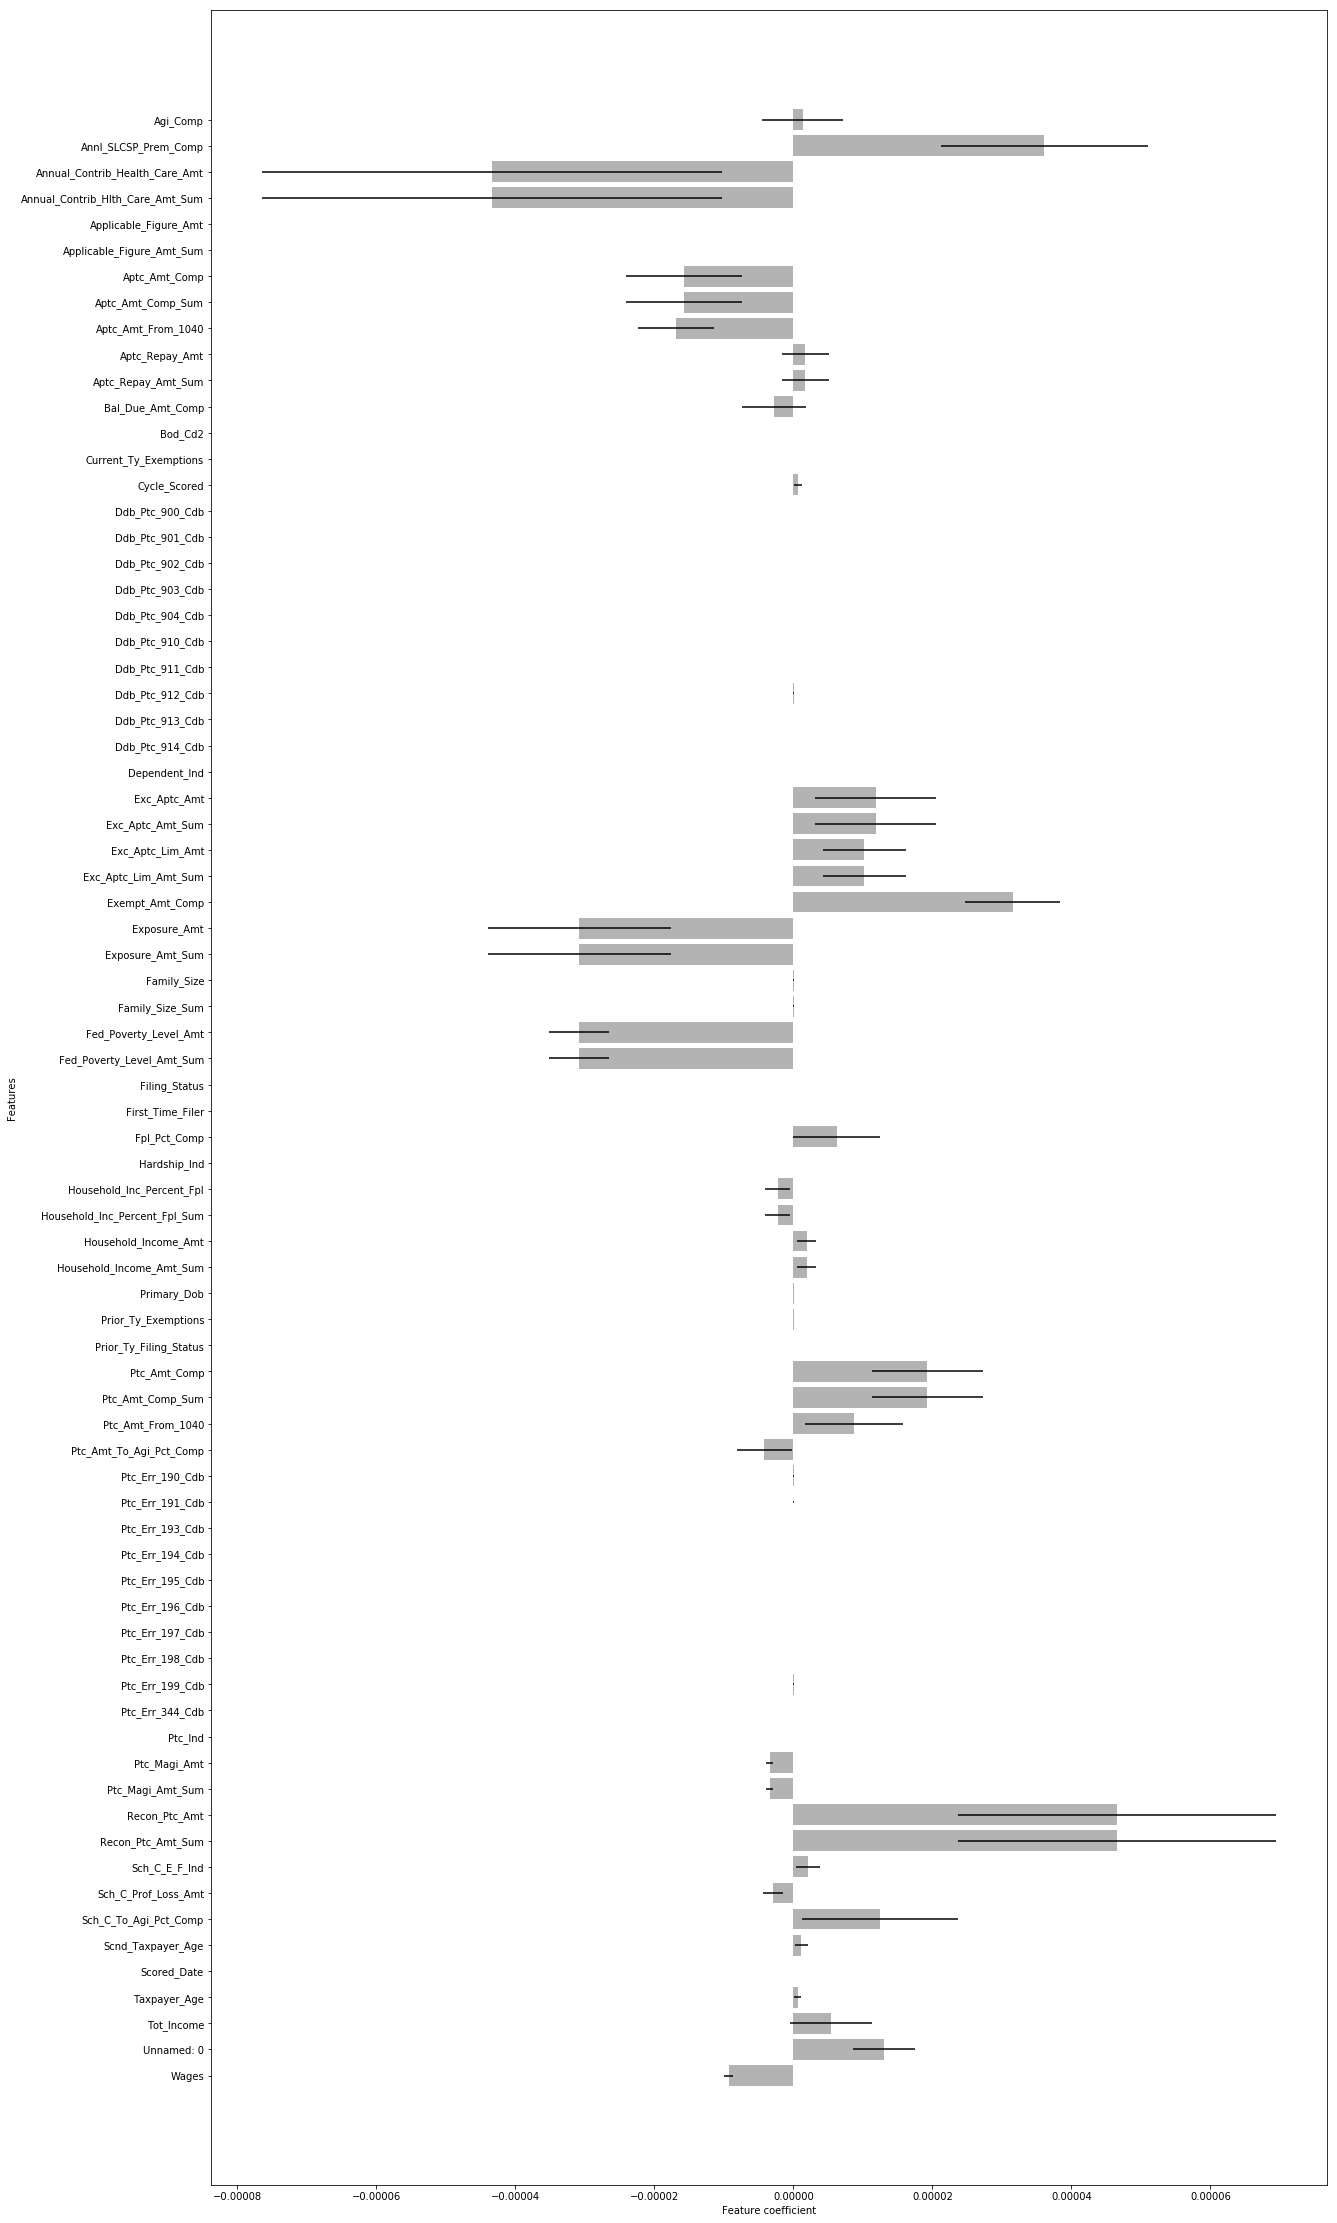

In [22]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression(C=1)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1
xerr=np.std(f_impo,axis=0)
plt.figure (figsize=(20,40))
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr, color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()

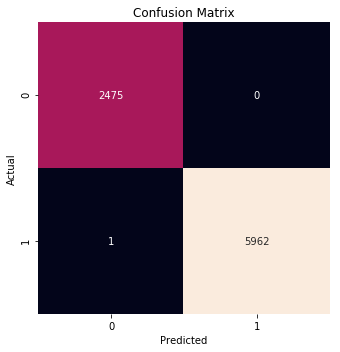

In [23]:
plt.figure(figsize=(5,5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute ROC curve and area the curve
def plot_roc(y_test,y_score):
    lw = 2
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=lw,
             label='ROC')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()
    
# Plot Precision-Recall curve
def plot_pr(y_test,y_score):
    lw = 2
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    plt.figure()
    plt.plot(recall, precision, lw=lw, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC={0:0.2f}'.format(average_precision))
    #plt.legend(loc="lower left")
    plt.show()

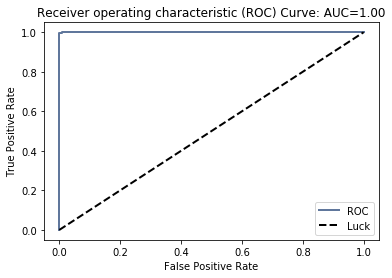

In [63]:
plot_roc(y_true,decfun)

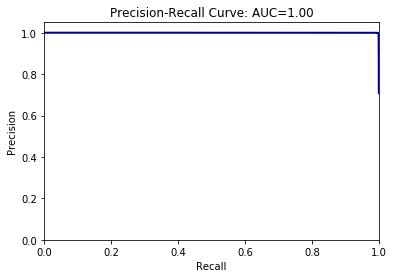

In [64]:
plot_pr(y_true,decfun)

The accuracy of the model is 74%, which is slightly better than the baseline model. We can see from the confusion matrix that the majority of actual positives are predicted to be positive; the true positive rate (aka recall) is an exceptional 93%. About three fourths of those predicted as positives are actual positives; the precision is 75% (the idea is 100%). 
The ROC curve shows the model is better than random. The area under the curve (AUC) is 0.67 (ideal is 1.0). As mentioned above, the recall of the dataset is exceptional while the precision is good at 75%, which is reflected in high AUC for the PR curve (0.80).

Random Forest

Decision trees are great for nonlinear and conditional relationships. They run fast, but are prone to overfitting. To combat the lack of generalization, best practices include the use of a random forest instead of a single decision tree. Random forest runs a number of decision trees on a subset of the data, and averages to improve prediction and counteract overfitting. In addition, RF automatically does feature selection.

After splitting the data into training and test sets, I will first run a baseline Random Forest model. As a reminder, I won't need to do feature selection first as it's done automtically in a Random Forest model. 

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

In [45]:
#assign X and Y values for dataset---X are the input variables and Y is the target variable
X = PTCAudit3.drop(['AUDIT_RESULT2'], axis=1).values
y = PTCAudit3.AUDIT_RESULT2.values
Xlabels = PTCAudit3.drop(['AUDIT_RESULT2'], axis=1).columns

In [46]:
# split the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [ ]:
#run RF classifier model--feature selection is automatically applied
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

So far, our Random Forest model is only correctly classifying about 76% of cases. I used GridSearch to see if parameter tuning could improve the model's performance. 

In [33]:
nEs = [10, 100, 500]
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, {'n_estimators':nEs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'n_estimators': 500}
Accuracy score: 1.000


In [35]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.000
Accuracy score of test set: 0.768


In [36]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.000
Accuracy score of test set: 0.757


In [37]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.989
Accuracy score of test set: 0.727


According to GridSearch, I determined the ideal number of estimators was 500 for this dataset. I then condudcted a K-fold (5 folds) cross validation using number estimators=500 (best parameter) and printed the accuracy for each fold to see if model performance improved.

In [ ]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0

clf = RandomForestClassifier(n_estimators=500)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.predict_proba(X[test])[:,1]
    f_impo[n,:] = clf.feature_importances_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [ ]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Parameter adjustment and K-fold cross validation only very slightly improved model performance.


After applying parameter tuning and K-fold cross validation, I further assessed model performance by plotting the mean and standard deviation of each feature coeifficient as well as a confusion matrix, a ROC curve, and a PRC curve.

In [ ]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression(C=1)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1
xerr=np.std(f_impo,axis=0)
plt.figure (figsize=(20,40))
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr, color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()

In [ ]:
xerr=np.std(f_impo,axis=0)
plt.figure()
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr, color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout();

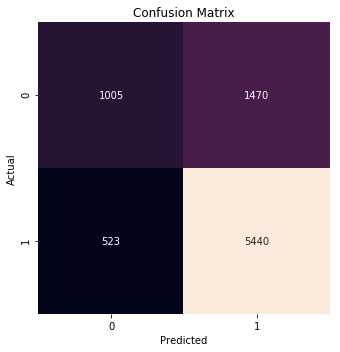

In [67]:
plt.figure(figsize=(5,5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

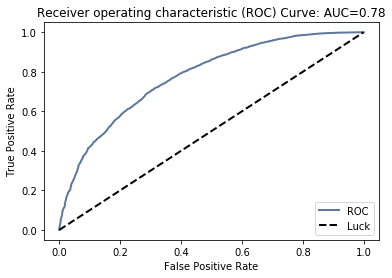

In [68]:
plot_roc(y_true,decfun)

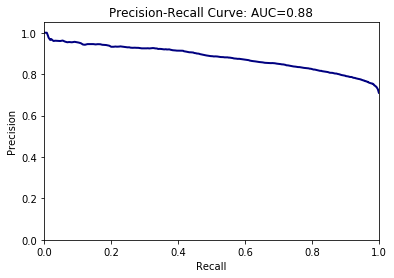

In [69]:
plot_pr(y_true,decfun)

The accuracy of the model is 77%, which is slightly better than the baseline model. We can see from the confusion matrix that the majority of actual positives are predicted to be positive; the true positive rate (aka recall) is an exceptional 91%. About four of five of those predicted as positives are actual positives; the precision is 79% (the ideal is 100%). The ROC curve shows the model is better than random. The area under the curve (AUC) is 0.78 (ideal is 1.0). As mentioned above, the recall of the dataset is exceptional while the precision is good at 79%, which is reflected in high AUC for the PR curve (0.88).

3.3. Support Vector Machines

Support Vector Machines are great for non-linear models, since you can have arbitrarily more dimensions with little additional computational cost, because of the "kernel trick". We will try a series of kernels. It is more difficult to glean learnings from SVM - the coefficients especially for higher order models don't necessarily indicate feature importance.

It is recommended that the data be normalized; SVM is not scale invariant. The SVM algorithm in sci-kit learn takes in both [-1,1] or [0,1]. The columns that will be normalized are number of projects, average monthly hours, time spent in company; all other columns have values between 0 and 1.

First, I used a linear SVC to extract extract only important features from the dataset.

In [9]:
#Import Linear SVC and print original features
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
X, y = PTCAudit3.values, PTCAudit3.AUDIT_RESULT2
X_cols=PTCAudit3.columns
X.shape

(8438, 77)

Our original dataset has 77 features. I used a Linear SVC to determine most important features and printed out a list of features the Linear SVC selected. 

In [10]:
#Use Linear SVC to select only top features and print out which ones it selected
lsvc = LinearSVC(C=.01, penalty='l1',
                 dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape
print(X_new.shape) 
print(PTCAudit.columns)
print(model.get_support())

(8438, 11)
Index(['AGIFinal', 'AUDIT_RESULT2', 'Agi_Comp', 'Annl_SLCSP_Prem_Comp',
       'Annual_Contrib_Health_Care_Amt', 'Annual_Contrib_Hlth_Care_Amt_Sum',
       'Applicable_Figure_Amt', 'Applicable_Figure_Amt_Sum', 'Aptc_Amt_Comp',
       'Aptc_Amt_Comp_Sum', 'Aptc_Amt_From_1040', 'Aptc_Repay_Amt',
       'Aptc_Repay_Amt_Sum', 'Avs_Bypass_Ind', 'Bal_Due_Amt_Comp',
       'Bal_Due_Amt_CompFinal', 'Bod_Cd2', 'City', 'Current_Ty_Exemptions',
       'Cycle_Scored', 'Cycle_Selected', 'Cycle_Updated', 'DISP_CD',
       'Ddb_Ptc_900_Cdb', 'Ddb_Ptc_901_Cdb', 'Ddb_Ptc_902_Cdb',
       'Ddb_Ptc_903_Cdb', 'Ddb_Ptc_904_Cdb', 'Ddb_Ptc_910_Cdb',
       'Ddb_Ptc_911_Cdb', 'Ddb_Ptc_912_Cdb', 'Ddb_Ptc_913_Cdb',
       'Ddb_Ptc_914_Cdb', 'Dependent_Ind', 'Dln', 'Exc_Aptc_Amt',
       'Exc_Aptc_Amt_Sum', 'Exc_Aptc_Lim_Amt', 'Exc_Aptc_Lim_Amt_Sum',
       'Exempt_Amt_Comp', 'Exposure_Amt', 'Exposure_AmtFinal',
       'Exposure_Amt_Sum', 'Family_Size', 'Family_Size_Sum',
       'Fed_Poverty_Level_Amt

Linear SVC selected 11 of the original 77 variables as the most important. We will use those going forward.

I ran a series of SVC models. I will use feature selection to ensure the model is only using important features. 

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [12]:
#assign X and Y values for dataset---X are the input variables and Y is the target variable
y = PTCAudit3.AUDIT_RESULT2.values

In [16]:
#split data and run default model
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.949
Accuracy score of test set: 0.955


I will run GridSeach to find the best parameters and then use those in a k-fold cross validation to see if model performance improves. 

In [ ]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
svc = SVC(kernel='linear')
clf = GridSearchCV(svc, {'C':Cs,'gamma':gammas})
clf.fit(X_new, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X_new,y)))

Once I determined what value of C provides a best score, I applied k-fold cross validation and printed the accuracy of each fold and the average. 

In [ ]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
y_score = np.zeros((len(y),2))
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = SVC(kernel='linear',C=0.1,gamma=0.00001,probability=True)

for train, test in StratifiedKFold(nfold).split(X_new, y):
    clf.fit(X_new[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X_new[test])
    y_true[offset:(offset+len(test))] = y[test]
    y_score[offset:(offset+len(test))] = clf.predict_proba(X_new[test])
    n_scor[n] = clf.score(X_new[test],y[test])
    offset += len(test)
    n += 1

In [ ]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

After applying feature selection, parameter tuning, and K-fold cross validation, I further assessed model performance by plotting the mean and standard deviation of each feature coeifficient as well as a confusion matrix, a ROC curve, and a PRC curve.

In [ ]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression(C=1)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1
xerr=np.std(f_impo,axis=0)
plt.figure (figsize=(20,40))
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr, color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

In [ ]:
plot_roc(y_true,decfun)

In [ ]:
plot_pr(y_true,decfun)

The accuracy of the model is 77%, which is slightly better than the baseline model. We can see from the confusion matrix that the majority of actual positives are predicted to be positive; the true positive rate (aka recall) is an exceptional 91%. About four of five of those predicted as positives are actual positives; the precision is 79% (the ideal is 100%). The ROC curve shows the model is better than random. The area under the curve (AUC) is 0.78 (ideal is 1.0). As mentioned above, the recall of the dataset is exceptional while the precision is good at 79%, which is reflected in high AUC for the PR curve (0.88).

4.Results

Random forest was the best model for our data, for prediction and for suggesting which features had the most impact. The accuracy of the model even on test data approached 99%, with beautiful ROC and precision-recall curves. The features that random forest highlighted as the most important were satisfaction level, last evaluation, number of projects, monthly hours, and time spent at the company.

Logistic regression and SVM was also applied to the data. As might be expected, linear models like logistic regression and SVM with a linear kernel did not predict well, with accuracy little better than predicting that everyone stays. These models produced 90% accuracy, which is still far below the 99% accuracy of random forest. SVM with the rbf kernel also did much better than the linear kernel, with an accuracy of 96% on test data, but again, random forest outperformed SVM, and also provides feature importance.

The features with the most importance from random forest modeling are:
satisfaction level
last evaluation
number of projects
average monthly hours
time spent at the company

Model	                      accuracy score	AUC-ROC	AUC-PR
baseline	                    0.76		
logistic regression (linear)	0.77	          0.80	 0.45
random forest	                0.99	          0.99	 0.99
SVM (linear kernel)	            0.77	          0.79	 0.50

